# <font color='blue'>Data Science Academy</font>
# <font color='blue'>Deep Learning Frameworks</font>

In [1]:
# Versão da Linguagem Python
from platform import python_version
print('Versão da Linguagem Python Usada Neste Jupyter Notebook:', python_version())

Versão da Linguagem Python Usada Neste Jupyter Notebook: 3.7.6


## Mini-Projeto
### Prevendo a Ocorrência de Desastres Analisando Palavras-Chave em Textos nas Redes Sociais

O Twitter se tornou um importante canal de comunicação em tempos de emergência.

A onipresença dos smartphones permite que as pessoas anunciem uma emergência que estão observando em tempo real. Por esse motivo, mais agências estão interessadas em monitorar programaticamente o Twitter (ou seja, organizações de auxílio a desastres e agências de notícias).

Mas nem sempre é claro se as palavras de uma pessoa estão realmente anunciando um desastre.

Este Mini-Projeto mostra um pipeline completo para a tarefa da Processamento de Linguagem Natural de classificação de texto. Especificamente, ele tenta classificar se um tweet descreve um desastre real ou falso.

O pipeline é composto por:

* Limpeza e Pré-Processamento
* Engenharia de Atributos
* Modelo Embeddings de Palavras Pré-Treinado
* Modelo de Deep Learning - Rede Neural Recorrente BiLSTM

## Definição do Problema

Neste Mini-Projeto você estará prevendo se um determinado tweet é sobre um desastre real ou não. Se for desastre a previsão deve ser 1. Caso contrário, 0.

Cada amostra no conjunto de treino e teste tem as seguintes informações:

- O texto de um tweet.
- Uma palavra-chave desse tweet (embora isso possa estar em branco).
- O local de onde o tweet foi enviado (também pode estar em branco).


## Dataset

Usaremos um conjunto de dados baseado no dataset público: Mensagens Multilíngues de Resposta a Desastres

Os dados contém um conjunto de mensagens relacionadas à resposta a desastres, cobrindo vários idiomas, adequado para categorização de texto e tarefas relacionadas ao processamento de linguagens naturais.

Detahes sobre o dataset podem ser obtidos no endereço abaixo. O Dataset de treino e teste acompanham este Jupyter Notebook.

https://appen.com/datasets/combined-disaster-response-data/

Este Mini-Projeto tem nível intermediário/avançado e os principais temas aqui abordados serão estudados em detalhes no curso Deep Learning II e Processamento de Linguagem Natural da Formação IA.

In [2]:
# Para atualizar um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install -U nome_pacote

# Para instalar a versão exata de um pacote, execute o comando abaixo no terminal ou prompt de comando:
# pip install nome_pacote==versão_desejada

# Depois de instalar ou atualizar o pacote, reinicie o jupyter notebook.

# Instala o pacote watermark. 
# Esse pacote é usado para gravar as versões de outros pacotes usados neste jupyter notebook.
!pip install -q -U watermark

In [3]:
# Instala o pacote gensim
!pip install -q gensim 

In [4]:
# Imports
import re
import gc
import nltk
import torch
import sklearn
import gensim
import numpy as np
import pandas as pd
import torch.nn as nn
import matplotlib.pyplot as plt
import seaborn as sns
import gensim.downloader as api
from collections import Counter
from copy import deepcopy
from nltk.tokenize import TweetTokenizer
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from nltk.corpus import stopwords
from gensim.models.word2vec import Word2Vec
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
%matplotlib inline

unable to import 'smart_open.gcs', disabling that module


In [5]:
# Versões dos pacotes usados neste jupyter notebook
%reload_ext watermark
%watermark -a "Data Science Academy" --iversions

re      2.2.1
torch   1.4.0+cu100
nltk    3.4.5
gensim  3.8.1
sklearn 0.21.3
pandas  1.0.3
seaborn 0.10.0
numpy   1.18.2
Data Science Academy


In [6]:
# Determina o device onde o modelo será executado
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(f'Dispositivo sendo usado: {device}')

Dispositivo sendo usado: cuda


In [7]:
!nvidia-smi

Thu Apr 23 01:50:18 2020       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 440.64.00    Driver Version: 440.64.00    CUDA Version: 10.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  TITAN X (Pascal)    On   | 00000000:05:00.0  On |                  N/A |
| 24%   41C    P8    11W / 250W |    104MiB / 12194MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   1  GeForce GTX 108...  On   | 00000000:09:00.0 Off |                  N/A |
| 23%   34C    P8     9W / 250W |     12MiB / 11178MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
|   2  T

In [8]:
# Download do etiquetador NLTK
nltk.download('averaged_perceptron_tagger')

[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/dmpm/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


True

In [9]:
# Download do léxico
nltk.download('vader_lexicon')

[nltk_data] Downloading package vader_lexicon to
[nltk_data]     /home/dmpm/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!


True

## Limpeza e Pré-Processamento

Criaremos diversas funções que serão aplicadas aos dados para o processo de limpeza.

### Limpeza do Texto

Caso tenha dúvida sobre aplicação de expressão regular em Python aqui você encontra a tabela de metacaracteres:

https://www.w3schools.com/python/python_regex.asp

In [10]:
# Função para normalização do texto
def normaliza_tweet(text):

    # Altera hiperlinks para tokens '<url>'
    output = re.sub(r'http[s]{0,1}://t.co/[a-zA-Z0-9]+\b', '<url>', text)
    
    # Separa todos os sinais '#' da palavra seguinte com um espaço em branco
    output = re.sub(r'#(\w+)', r'# \1', output)

    return output

In [11]:
# Função para tokenização
# Tokeniza as sentenças, mas deixa hastags (#) e users (@)
def tokenize(tokenizer, string):    
    tokenized = tokenizer.tokenize(string)
    return tokenized

In [12]:
# Função que retorna a string tokenizada (lista) com números substituídos por um token numérico
def numero_tokens(tokenized_string, num_token = '<number>'):
    
    # Cria uma lista de tuplas (palavra, tags POS)
    pos_tagged = nltk.pos_tag(tokenized_string)
    
    # Encontre índices de número de POS tags
    num_indices = [idx for idx in range(len(pos_tagged)) if pos_tagged[idx][1] == 'CD']
    
    # Substitui números por token
    for idx in num_indices:
        tokenized_string[idx] = num_token
        
    return tokenized_string    

In [13]:
# Função que executa todas as funções de limpeza de texto
def preprocessa_texto(tokenizer, string):    
    return numero_tokens(tokenize(tokenizer, normaliza_tweet(string)))

In [14]:
# Retorna palavra chave tokenizada e limpa
def preprocessa_keyword(keyword):
    
    # Retorna None se a palavra-chave for np.nan
    if type(keyword) == np.float and np.isnan(keyword):
        return
    
    # Replace '%20' com espaço, minúsculo e tokenizado
    output = re.sub(r'%20', ' ', keyword)
    output = output.lower()
    output = output.split()
    return output

O pipeline de limpeza de texto está pronto. Vamos agora preparar as funções de engenharia de atributos.

## Funções Para Engenharia de Atributos

In [15]:
# Função que retorna um número inteiro que indica palavras com todas as letras maiúsculas.
def count_all_caps(text):
    return len([word for word in text.split() if word.isupper()])

In [16]:
# Função que retorna um número inteiro que indica se a primeira letra da palavra é maiúscula.
def count_capitalized(text):
    return len([word for word in text.split() if word.istitle()])

In [17]:
# Função que retorna um número inteiro indicando total de palavras no tweet.
def count_words(text):
    return len(text.split())

In [18]:
# Função que adiciona 4 colunas de pontuações de análise de sentimento a um DataFrame. 
def sentiment_analyze_df(df, column):

    # Instância do analisador de sentimento
    sid = SentimentIntensityAnalyzer()
    
    # Cria uma matriz e preenche com pontuações de cada um dos df[coluna]
    output_values = np.zeros((len(df), 4))
    for tup in df.itertuples():
        output_values[tup.Index, :] = list(sid.polarity_scores(' '.join(getattr(tup, column))).values())
    
    # Adiciona coluna à entrada DataFrame
    for idx, col in enumerate(['sent_neg', 'sent_neu', 'sent_pos', 'sent_compound']):
        df[col] = output_values[:, idx]

## Funções Word Embedding

### Text embedding

In [19]:
# Função que retorna o vetor embedding da palavra de entrada
def get_word_vec(embedding_model, use_norm, word):

    if word[0] == '@':
        return embedding_model.word_vec('<user>', use_norm = use_norm)
        
    elif word == '#':
        return embedding_model.word_vec('<hashtag>', use_norm = use_norm)

    elif word in embedding_model.vocab:
        return embedding_model.word_vec(word, use_norm = use_norm)

    else:
        return embedding_model.word_vec('<UNK>', use_norm = use_norm)

In [20]:
# Função que retorna vetores embedding dos tweets
def text_to_vectors(embedding_model, use_norm, tokenized_text):
    vectors = [get_word_vec(embedding_model, use_norm, word) for word in tokenized_text]
    vectors = np.array(vectors)
    
    return vectors

In [21]:
# Função que retorna uma matriz de vetores embedding dos textos com dimensões (seq_len, embedding)
def trim_and_pad_vectors(text_vectors, embedding_dimension, seq_len):

    # Instancia matriz de 0's 
    output = np.zeros((seq_len, embedding_dimension))

    # Ajusta tweets mais longos para seq_len 
    trimmed_vectors = text_vectors[:seq_len]

    # Determina o índice de fim do padding e começo do tweet embedding
    end_of_padding_index = seq_len - trimmed_vectors.shape[0]

    # Output
    output[end_of_padding_index:] = trimmed_vectors

    return output

In [22]:
# Retorna representações embedding to texto de entrada tokenizado
def embedding_preprocess(embedding_model, use_norm, seq_len, tokenized_text):
    
    # Obtém a matriz com vetores embedding (tweet length, embedding_dimension)
    text_vectors = text_to_vectors(embedding_model, use_norm, tokenized_text)
    
    # Output
    output = trim_and_pad_vectors(text_vectors, embedding_model.vector_size, seq_len)
    
    return output

### Keyword Embedding

In [23]:
# Função que retorna vetores embedding das palavras chave
def keyword_to_avg_vector(embedding_model, use_norm, tokenized_keyword):
    
    # Retorna um vetor de zeros se tokenized_keyword é None
    if tokenized_keyword is None:
        return np.zeros((1, embedding_model.vector_size))
    
    # Se não, calclula o vetor embedding médio
    vectors = [get_word_vec(embedding_model, use_norm, word) for word in tokenized_keyword]
    vectors = np.array(vectors)
    avg_vector = np.mean(vectors, axis = 0)
    avg_vector = avg_vector.reshape((1, embedding_model.vector_size))
    return avg_vector

## Preparação do Modelo Embedding

In [24]:
# Vamos carregar um modelo pré-treinado com dados do twitter
model_glove_twitter = api.load("glove-twitter-100")

In [25]:
# Cria um vetor randômico para representar o token <UNK>  (unseen word)
random_vec_for_unk = np.random.uniform(-1, 1, size = model_glove_twitter.vector_size).astype('float32')
random_vec_for_unk = random_vec_for_unk.reshape(1, model_glove_twitter.vector_size)
random_vec_for_unk

array([[ 0.01384434,  0.49052075,  0.49664807, -0.05438766,  0.4184903 ,
        -0.4251542 , -0.5994017 , -0.47602206,  0.8632609 , -0.89985335,
         0.8763597 , -0.53400373, -0.20539917,  0.12515701, -0.8655545 ,
         0.4937097 , -0.20371827, -0.4258548 , -0.46014646, -0.84654343,
         0.24218348, -0.968907  , -0.823803  ,  0.439094  , -0.04996118,
        -0.4370404 , -0.71532273,  0.9304626 ,  0.8828252 ,  0.58126444,
         0.7191156 , -0.5426161 ,  0.1901668 ,  0.35590264,  0.58323765,
         0.8008478 , -0.63063574,  0.7208213 , -0.32343465,  0.66793597,
        -0.21697602,  0.35139206,  0.3700516 ,  0.25898993, -0.5254402 ,
         0.6108485 , -0.6815279 ,  0.18161105, -0.6179251 , -0.55743706,
         0.320094  ,  0.71677375,  0.20855114, -0.9831811 ,  0.6551467 ,
        -0.02479845, -0.6974939 ,  0.53109473,  0.18305196, -0.8849183 ,
         0.09849277, -0.33412308,  0.22011864, -0.81929684,  0.00806397,
         0.0946544 , -0.43247125, -0.35290623,  0.9

In [26]:
# Testa similaridade
model_glove_twitter.most_similar(random_vec_for_unk)

[('escorpião', 0.42616885900497437),
 ('aquario', 0.41469621658325195),
 ('touro', 0.407369464635849),
 ('luftdruck', 0.40644538402557373),
 ('capricórnio', 0.38853275775909424),
 ('lá!nn', 0.38354912400245667),
 ('മരിച', 0.3834708631038666),
 ('entrevistador', 0.3827832043170929),
 ('nnò', 0.3821023106575012),
 ('inmet', 0.37908029556274414)]

In [27]:
# Adiciona o vetor randômico ao modelo
model_glove_twitter.add(['<UNK>'], random_vec_for_unk, replace = True)

In [28]:
# Gera vetores normalizados e substitui originais
model_glove_twitter.init_sims(replace = True)

## Pré-Processamento

In [29]:
# Carrega os dados de treino
dados_treino = pd.read_csv('dados/dados_treino.csv')
dados_treino.head()

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1


### Limpeza

In [30]:
# Cria um tokenizador que transforma para letra minúscula, reduz o comprimento e preserva o usuário ('@user')
tokenizer = TweetTokenizer(preserve_case = False, reduce_len = True, strip_handles = False) 

In [31]:
# Normaliza e tokeniza texto
dados_treino['tok_norm_text'] = [preprocessa_texto(tokenizer, text) for text in dados_treino['text']]

In [32]:
# Normaliza e tokeniza keyword
dados_treino['keyword'] = dados_treino['keyword'].apply(preprocessa_keyword)

### Engenharia de Atributos

In [33]:
# Aplica as funções aos dados
dados_treino['num_all_caps'] = dados_treino['text'].apply(count_all_caps)
dados_treino['num_caps'] = dados_treino['text'].apply(count_capitalized)
dados_treino['num_words'] = dados_treino['text'].apply(count_words)

In [34]:
# Cria um scaler para que todos os recursos estejam dentro do range [-1, 1]
scaler = MinMaxScaler(feature_range=(-1, 1))

In [35]:
# Aplica o scaler
columns_to_scale = ['num_all_caps', 'num_caps', 'num_words']
scaler.fit(dados_treino[columns_to_scale])
dados_treino[columns_to_scale] = scaler.transform(dados_treino[columns_to_scale])

In [36]:
# Cria recursos de análise de sentimentos
sentiment_analyze_df(dados_treino, 'tok_norm_text')

In [37]:
# Visualiza
dados_treino.head()

,id,keyword,location,text,target,tok_norm_text,num_all_caps,num_caps,num_words,sent_neg,sent_neu,sent_pos,sent_compound
0,1,None,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, #, ea...",-0.92,-0.565217,-0.200000,0.000,0.851,0.149,0.2732
1,4,None,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, ., canada]",-1.00,-0.565217,-0.600000,0.286,0.714,0.000,-0.3400
2,5,None,NaN,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, ', shelter, in, pl...",-1.00,-0.826087,0.400000,0.095,0.905,0.000,-0.2960
3,6,None,NaN,"13,000 people receive #wildfires evacuation or...",1,"[<number>, people, receive, #, wildfires, evac...",-1.00,-0.913043,-0.533333,0.000,1.000,0.000,0.0000
4,7,None,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, this, photo, from, ruby, #, ...",-1.00,-0.739130,0.000000,0.000,1.000,0.000,0.0000


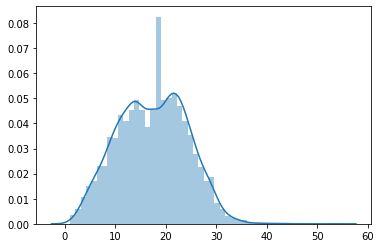

In [38]:
# Plot
sns.distplot([len(tok) for tok in dados_treino['tok_norm_text']])

Parece que a maioria dos textos tem menos de 35 palavras. <br>
Portanto, uma escolha razoável entre perda de dados e complexidade computacional será escolher o tamanho máximo de sequências igual a 35, ou seja, aparando (padding) o texto após a 35ª palavra.

### Atributos Textuais Para Representação Embedding de Palavras

In [39]:
# Sequência máxima
sequence_max_length = 30

In [40]:
# Gera o embedding do texto
dados_treino['text_embedding'] = [embedding_preprocess(embedding_model = model_glove_twitter, 
                                                       use_norm = True, 
                                                       seq_len = sequence_max_length, 
                                                       tokenized_text = text) 
                                  for text in dados_treino['tok_norm_text']]

In [41]:
# Gera o embedding da palavra chave
dados_treino['keyword_embedding'] = [keyword_to_avg_vector(embedding_model = model_glove_twitter, 
                                                           use_norm = True, 
                                                           tokenized_keyword = keyword) 
                                     for keyword in dados_treino['keyword']]

In [42]:
# Visualiza
dados_treino.head()

,id,keyword,location,text,target,tok_norm_text,num_all_caps,num_caps,num_words,sent_neg,sent_neu,sent_pos,sent_compound,text_embedding,keyword_embedding
0,1,None,NaN,Our Deeds are the Reason of this #earthquake M...,1,"[our, deeds, are, the, reason, of, this, #, ea...",-0.92,-0.565217,-0.200000,0.000,0.851,0.149,0.2732,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,4,None,NaN,Forest fire near La Ronge Sask. Canada,1,"[forest, fire, near, la, ronge, sask, ., canada]",-1.00,-0.565217,-0.600000,0.286,0.714,0.000,-0.3400,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,5,None,NaN,All residents asked to 'shelter in place' are ...,1,"[all, residents, asked, to, ', shelter, in, pl...",-1.00,-0.826087,0.400000,0.095,0.905,0.000,-0.2960,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,6,None,NaN,"13,000 people receive #wildfires evacuation or...",1,"[<number>, people, receive, #, wildfires, evac...",-1.00,-0.913043,-0.533333,0.000,1.000,0.000,0.0000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,7,None,NaN,Just got sent this photo from Ruby #Alaska as ...,1,"[just, got, sent, this, photo, from, ruby, #, ...",-1.00,-0.739130,0.000000,0.000,1.000,0.000,0.0000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


### Representação Embedding Para Todos os Recursos Escolhidos

In [43]:
# Função que retorna um array numpy contendo valores únicos no comprimento seq_len
def _single_values_repeat(seq_len, static_single_values):
    output = static_single_values.reshape((1, len(static_single_values)))
    output = np.repeat(output, seq_len, axis = 0)
    return output

In [44]:
# Retorna uma array numpy de stacked embedding vectors
def _static_embedding_repeat(seq_len, static_embedding_values):    
    horizontally_stacked = np.hstack(static_embedding_values)
    output = np.repeat(horizontally_stacked, seq_len, axis = 0)
    return output

In [45]:
# Função que retorna as representações embedding de todos os atributos
def concatenate_embeddings(df, 
                           embedding_model, 
                           seq_len, 
                           sequence_embedding_col, 
                           static_embedding_cols, 
                           static_singles_cols):
    
    # Dimensões do embedding
    emb_dim = embedding_model.vector_size
    
    # Matriz de saída
    output = np.zeros((len(df), seq_len, len(static_singles_cols) + len(static_embedding_cols) * emb_dim + emb_dim))
    
    # Loop
    for idx, row in df.iterrows():
        
        single_vals = _single_values_repeat(seq_len, row[static_singles_cols].values)
        static_emb_vals = _static_embedding_repeat(seq_len, row[static_embedding_cols])
        seq_emb_vals = row[sequence_embedding_col]

        # Stack embeddings e atributos
        row_embedding = np.hstack((single_vals, static_emb_vals, seq_emb_vals))

        output[idx, :, :] = row_embedding
        
    return output

In [46]:
# Cria uma representação embedding final de todos os recursos escolhidos para treino
embedding_matrix = concatenate_embeddings(df = dados_treino, 
                                          embedding_model = model_glove_twitter, 
                                          seq_len = sequence_max_length,
                                          sequence_embedding_col = 'text_embedding',
                                          static_embedding_cols = ['keyword_embedding'],
                                          static_singles_cols = ['num_all_caps', 
                                                                 'num_caps', 
                                                                 'num_words', 
                                                                 'sent_neg', 
                                                                 'sent_neu', 
                                                                 'sent_pos', 
                                                                 'sent_compound'])

In [47]:
# Shape
embedding_matrix.shape

(7613, 30, 207)

## Construção do Modelo

Implementação PyTorch de um Modelo Bi-Directional LSTM RNN

In [48]:
# Algoritmo do Modelo BiLSTM que estende a classe nn.Module
class BiLSTM(nn.Module):

    # Método construtor
    def __init__(self, embedding_dim, hidden_dim, num_layers, num_classes, batch_size, dropout, device):
        super(BiLSTM, self).__init__()
        
        # Inicialização dos atributos
        self.hidden_dim = hidden_dim
        self.batch_size = batch_size
        self.num_layers = num_layers

        # Dropout para reduzir o overfitting
        self.dropout = nn.Dropout(p = dropout)

        # Modelo LSTM
        self.lstm = nn.LSTM(input_size = embedding_dim, 
                            hidden_size = hidden_dim, 
                            num_layers = num_layers,
                            batch_first = True, 
                            dropout = dropout, 
                            bidirectional = True)
        
        # Camada totalmente conectada
        self.fc = nn.Linear(hidden_dim * 2, num_classes)
        
        # Device
        self.device = device
        
        # Listas para avaliações e plot
        self.train_loss = []
        self.train_acc = []
        self.val_loss = []
        self.val_acc = []
        
        # Um atributo para manter os melhores pesos do modelo (usado para avaliação)
        self.best_weights = deepcopy(self.state_dict())

    # Camadas ocultas e células de estado LSTM
    def _init_hidden(self, current_batch_size):
        h0 = torch.zeros(self.num_layers * 2, current_batch_size, self.hidden_dim).to(self.device)
        c0 = torch.zeros(self.num_layers * 2, current_batch_size, self.hidden_dim).to(self.device)
        return h0, c0

    # Forward Step
    def forward(self, x):

        # Forward LSTM
        h, c = self._init_hidden(current_batch_size = x.size(0))
        out, _ = self.lstm(x, (h, c))

        # Dropout
        out = self.dropout(out)

        # Decode do estado oculto para o último passo de tempo
        out = self.fc(out[:, -1, :])

        return out
    
    # Previsões
    def predict(self, x: torch.tensor):
        class_predictions = self(x).data
        _, predicted = torch.max(class_predictions, dim = 1)
        return predicted

    # Treinamento e avaliação com dados de validação
    def _train_evaluate(self, X_train, y_train, X_val, y_val, criterion):

        # Muda o modelo para modo de avaliação
        self.eval()

        # Calcula acurácia e perda nos dados de treino
        epoch_train_acc = (self.predict(X_train) == y_train).sum().item() / y_train.shape[0]
        epoch_train_loss = criterion(self(X_train), y_train).item()
        self.train_acc.append(epoch_train_acc)
        self.train_loss.append(epoch_train_loss)

        # Calcula acurácia e perda nos dados de validação
        if X_val is not None and y_val is not None:
            epoch_val_acc = (self.predict(X_val) == y_val).sum().item() / y_val.shape[0]
            epoch_val_loss = criterion(self(X_val), y_val).item()
            self.val_acc.append(epoch_val_acc)
            self.val_loss.append(epoch_val_loss)

            # Retorna valores de acurácia e perda
            return epoch_train_loss, epoch_train_acc, epoch_val_loss, epoch_val_acc

        # Retorna valores de acurácia e perda se não houver dataset de validação
        return epoch_train_loss, epoch_train_acc, None, None

    # Retorna um dicionário com as melhores épocas
    def best_epoch(self):
        best_train_loss_epoch = np.argmin(np.array(self.train_loss)) + 1
        best_train_acc_epoch = np.argmax(np.array(self.train_acc)) + 1

        output = {'Epoch de Menor Erro em Treino': best_train_loss_epoch, 
                  'Epoch de Melhor Acurácia em Treino': best_train_acc_epoch}

        if len(self.val_loss) > 0:
            best_val_loss_epoch = np.argmin(np.array(self.val_loss))
            best_val_acc_epoch = np.argmax(np.array(self.val_acc))

            output.update({'Epoch de Menor Erro em Validação': best_val_loss_epoch, 
                           'Epoch de Melhor Acurácia em Validação': best_val_acc_epoch})

        return output

    # Retorna um dicionário que contém o número de parâmetros totais e treináveis.
    def get_num_parameters(self):
        total_params = sum(p.numel() for p in self.parameters())
        trainable_params = sum(p.numel() for p in self.parameters() if p.requires_grad)
        return {'total_parameters': total_params, 'trainable_parameters': trainable_params}

    @staticmethod
    def _print_progress(epoch, train_loss, train_acc, val_loss, val_acc, improved, verbose=False):

        output = f'Epoch {str(epoch + 1).zfill(3)}:'
        output += f'\n\t Erro em Treinamento: {str(train_loss)[:5]} | Acurácia: {str(train_acc)[:5]}.'

        if val_loss is not None and val_acc is not None:
            output += f'\n\t Erro em Validação: {str(val_loss)[:5]} | Acurácia: {str(val_acc)[:5]}.'

        if improved:
            output += f' Houve aprendizado!'

        if verbose:
            print(output)

    # Método de treinamento
    def fit(self, X_train, y_train, X_val, y_val, epoch_num, criterion, optimizer, verbose = False):

        # Uma variável para determinar se deve atualizar os melhores pesos (e relatar o progresso)
        best_acc = 0.0

        # Divide o conjunto de dados em batches
        X_train_tensor_batches = torch.split(X_train, self.batch_size)
        y_train_tensor_batches = torch.split(y_train, self.batch_size)

        # Loop
        for epoch in range(epoch_num):

            # Define o modelo para o modo de treinamento 
            # No final de cada época é definido para o modo de avaliação
            self.train()

            for i, (X_batch, y_batch) in enumerate(zip(X_train_tensor_batches, y_train_tensor_batches)):

                # Forward pass
                outputs = self(X_batch)
                loss = criterion(outputs, y_batch)

                # Backward e otimização
                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

            # Calcula precisão e perda de treino e validação 
            train_loss, train_acc, val_loss, val_acc = self._train_evaluate(X_train, y_train, X_val, y_val, criterion)

            # Um booleano para determinar a precisão correta a ser considerada no progresso (Validação do treinamento)
            if X_val is not None and y_val is not None:
                accuracy = val_acc
            else:
                accuracy = train_acc

            # Se a precisão superar a melhor precisão anterior, imprime e atualiza a melhor precisão 
            # e os melhores pesos do modelo
            if accuracy > best_acc:
                self._print_progress(epoch, 
                                     train_loss, 
                                     train_acc, 
                                     val_loss, 
                                     val_acc, 
                                     improved = True, 
                                     verbose = verbose)
                best_acc = accuracy
                self.best_weights = deepcopy(self.state_dict())

            # else, print
            else:
                self._print_progress(epoch, 
                                     train_loss, 
                                     train_acc, 
                                     val_loss, 
                                     val_acc, 
                                     improved = False, 
                                     verbose = verbose)

        gc.collect()

In [49]:
# Função para o Plot
def plot_graphs(model):
    plt.figure(figsize = (6, 12))

    plt.subplot(311)
    plt.title("Acurácia")
    plt.xlabel("Epochs")
    plt.ylabel("Acurácia")
    plt.plot(range(1, len(model.train_acc)+1), model.train_acc, label = "Treino")

    plt.xticks(np.arange(0, len(model.train_acc)+1, 5))
    plt.legend()

    plt.subplot(312)
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.plot(range(1, len(model.train_loss)+1), model.train_loss, label = "Treino")

    plt.xticks(np.arange(0, len(model.train_acc)+1, 5))
    plt.legend()

    plt.tight_layout(pad=0.4, w_pad=0.5, h_pad=1.0)
    plt.show()

## Treinamento

In [50]:
# Hiperparâmetros
embedding_dim = embedding_matrix.shape[2]  
hidden_size = 50  
num_layers = 2  
num_classes = 2  
batch_size = 256  
dropout = 0.3 
num_epochs = 40
learning_rate = 0.0005  
weight_decay = 0.0005  

In [51]:
# Carrega os atributos
X_treino = torch.from_numpy(embedding_matrix).float().to(device)

In [52]:
# Carrega o label
y_treino = torch.from_numpy(dados_treino['target'].values).long().to(device)

In [53]:
# Cria o modelo
modelo = BiLSTM(embedding_dim, hidden_size, num_layers, num_classes, batch_size, dropout, device).to(device)

In [54]:
# Função de perda
criterion = nn.CrossEntropyLoss()

In [55]:
# Otimizador
optimizer = torch.optim.Adam(modelo.parameters(), lr = learning_rate, weight_decay = weight_decay)

In [56]:
# Treina o modelo
modelo.fit(X_train = X_treino, 
           y_train = y_treino, 
           X_val = None, 
           y_val = None,
           epoch_num = num_epochs, 
           criterion = criterion, 
           optimizer = optimizer, 
           verbose = True)

Epoch 001:
	 Erro em Treinamento: 0.676 | Acurácia: 0.570. Houve aprendizado!
Epoch 002:
	 Erro em Treinamento: 0.636 | Acurácia: 0.651. Houve aprendizado!
Epoch 003:
	 Erro em Treinamento: 0.547 | Acurácia: 0.734. Houve aprendizado!
Epoch 004:
	 Erro em Treinamento: 0.509 | Acurácia: 0.760. Houve aprendizado!
Epoch 005:
	 Erro em Treinamento: 0.479 | Acurácia: 0.779. Houve aprendizado!
Epoch 006:
	 Erro em Treinamento: 0.456 | Acurácia: 0.790. Houve aprendizado!
Epoch 007:
	 Erro em Treinamento: 0.450 | Acurácia: 0.795. Houve aprendizado!
Epoch 008:
	 Erro em Treinamento: 0.433 | Acurácia: 0.809. Houve aprendizado!
Epoch 009:
	 Erro em Treinamento: 0.431 | Acurácia: 0.810. Houve aprendizado!
Epoch 010:
	 Erro em Treinamento: 0.416 | Acurácia: 0.819. Houve aprendizado!
Epoch 011:
	 Erro em Treinamento: 0.418 | Acurácia: 0.814.
Epoch 012:
	 Erro em Treinamento: 0.415 | Acurácia: 0.816.
Epoch 013:
	 Erro em Treinamento: 0.415 | Acurácia: 0.819. Houve aprendizado!
Epoch 014:
	 Erro em Tre

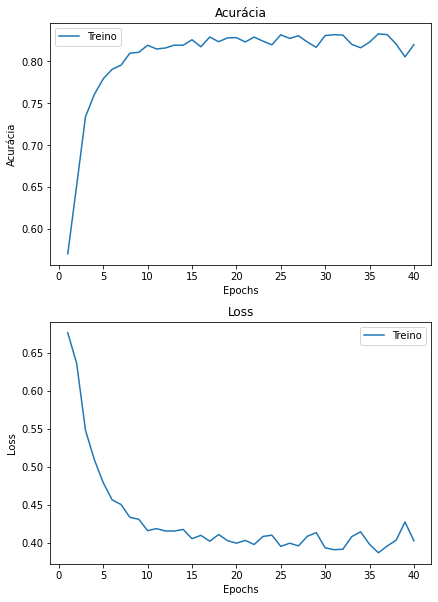

In [57]:
# Plot
plot_graphs(modelo)

## Fazendo Previsões

O mesmo processamento aplicado aos dados de treino deve ser aplicado aos dados de teste.

In [58]:
# Carrega os dados de teste
dados_teste = pd.read_csv('dados/dados_teste.csv')
dados_teste.head()

,id,keyword,location,text
0,0,NaN,NaN,Just happened a terrible car crash
1,2,NaN,NaN,"Heard about #earthquake is different cities, s..."
2,3,NaN,NaN,"there is a forest fire at spot pond, geese are..."
3,9,NaN,NaN,Apocalypse lighting. #Spokane #wildfires
4,11,NaN,NaN,Typhoon Soudelor kills 28 in China and Taiwan


In [59]:
# Normaliza e tokeniza o texto
dados_teste['tok_norm_text'] = [preprocessa_texto(tokenizer, text) for text in dados_teste['text']]

In [60]:
# Pré-processa as keywords
dados_teste['keyword'] = dados_teste['keyword'].apply(preprocessa_keyword)

In [61]:
# Extração de atributos
dados_teste['num_all_caps'] = dados_teste['text'].apply(count_all_caps)
dados_teste['num_caps'] = dados_teste['text'].apply(count_capitalized)
dados_teste['num_words'] = dados_teste['text'].apply(count_words)

In [62]:
# Padroniza os dados de teste da mesma forma que fizemos com dados de treino
dados_teste[columns_to_scale] = scaler.transform(dados_teste[columns_to_scale])

In [63]:
# Analisador de sentimentos
sentiment_analyze_df(dados_teste, 'tok_norm_text')

In [64]:
# Text embedding
dados_teste['text_embedding'] = [embedding_preprocess(embedding_model = model_glove_twitter, 
                                                      use_norm = True, 
                                                      seq_len = sequence_max_length, 
                                                      tokenized_text = text) 
                                 for text in dados_teste['tok_norm_text']]

In [65]:
# Keyword embedding
dados_teste['keyword_embedding'] = [keyword_to_avg_vector(embedding_model = model_glove_twitter, 
                                                          use_norm = True, 
                                                          tokenized_keyword = keyword) 
                                    for keyword in dados_teste['keyword']]

In [66]:
# Visualiza
dados_teste.head()

,id,keyword,location,text,tok_norm_text,num_all_caps,num_caps,num_words,sent_neg,sent_neu,sent_pos,sent_compound,text_embedding,keyword_embedding
0,0,None,NaN,Just happened a terrible car crash,"[just, happened, a, terrible, car, crash]",-1.00,-0.913043,-0.666667,0.659,0.341,0.000,-0.7003,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
1,2,None,NaN,"Heard about #earthquake is different cities, s...","[heard, about, #, earthquake, is, different, c...",-1.00,-0.913043,-0.466667,0.000,0.734,0.266,0.4404,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
2,3,None,NaN,"there is a forest fire at spot pond, geese are...","[there, is, a, forest, fire, at, spot, pond, ,...",-0.92,-0.913043,0.200000,0.251,0.749,0.000,-0.6159,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
3,9,None,NaN,Apocalypse lighting. #Spokane #wildfires,"[apocalypse, lighting, ., #, spokane, #, wildf...",-1.00,-0.826087,-0.800000,0.000,1.000,0.000,0.0000,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."
4,11,None,NaN,Typhoon Soudelor kills 28 in China and Taiwan,"[typhoon, soudelor, kills, <number>, in, china...",-1.00,-0.652174,-0.533333,0.333,0.667,0.000,-0.5423,"[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,...","[[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0,..."


In [67]:
# Representação embedding para os atributos de teste
teste_embedding_matrix = concatenate_embeddings(df = dados_teste, 
                                                embedding_model = model_glove_twitter, 
                                                seq_len = sequence_max_length,
                                                sequence_embedding_col = 'text_embedding',
                                                static_embedding_cols = ['keyword_embedding'],
                                                static_singles_cols = ['num_all_caps', 
                                                                       'num_caps', 
                                                                       'num_words', 
                                                                       'sent_neg', 
                                                                       'sent_neu', 
                                                                       'sent_pos', 
                                                                       'sent_compound'])

In [68]:
# Gera objeto com os atributos
X_teste = torch.from_numpy(teste_embedding_matrix).float().to(device)

In [69]:
# Previsões
preds = modelo.predict(X_teste)

In [70]:
# Concatena previsões e ids de cada registro de teste em um dataframe
final_preds = preds.cpu().numpy().reshape(-1,1)
ids = dados_teste['id'].values.reshape(-1,1)
data = np.hstack((ids, final_preds))

In [71]:
# Dataframe
previsoes = pd.DataFrame(data = data, columns = ['id', 'target'])

In [72]:
# Visualiza
previsoes.head()

,id,target
0,0,1
1,2,1
2,3,1
3,9,1
4,11,1


In [73]:
# Salva as previsões em disco
previsoes.to_csv('dados/previsoes.csv', index = False)

# Fim